In [2]:
# This notebook illustrates example outputs from Funman, and how to work with the ParameterSpace object it creates.

# The file scratch/hackathon/hackathon_fall_2023_demo_terarrium.py was used to generate the outputs rendered here.

SAVED_RESULTS_DIR = "./out"

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools
from funman import FunmanWorkRequest, EncodingSchedule

import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
from funman import FUNMANConfig
import logging
from funman_demo import summarize_results



RESOURCES = "../resources"
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "terrarium-tests")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR,"seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "seird_request.json"
)


# EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "stratified")
# MODEL_PATH = os.path.join(
#     EXAMPLE_DIR,"model_amr.json"
# )
# REQUEST_PATH = os.path.join(
#     EXAMPLE_DIR, "model_amr_request.json"
# )


# %load_ext autoreload
# %autoreload 2

2024-02-26 22:44:44,140 - funman.server.worker - INFO - FunmanWorker running...
2024-02-26 22:44:44,142 - funman.server.worker - INFO - Starting work on: 3a163a7f-42d9-4de6-a6fe-19c1566b6357
2024-02-26 22:44:52,593 - funman.scenario.consistency - INFO - 3{3}:	[+]
2024-02-26 22:44:52,593 - funman.api.run - INFO - Dumping results to ./out/3a163a7f-42d9-4de6-a6fe-19c1566b6357.json
2024-02-26 22:44:52,596 - funman.server.worker - INFO - Completed work on: 3a163a7f-42d9-4de6-a6fe-19c1566b6357
2024-02-26 22:45:02,614 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-02-26 22:45:02,655 - funman.server.worker - INFO - FunmanWorker exiting...
2024-02-26 22:45:02,657 - funman.server.worker - INFO - Worker.stop() completed.


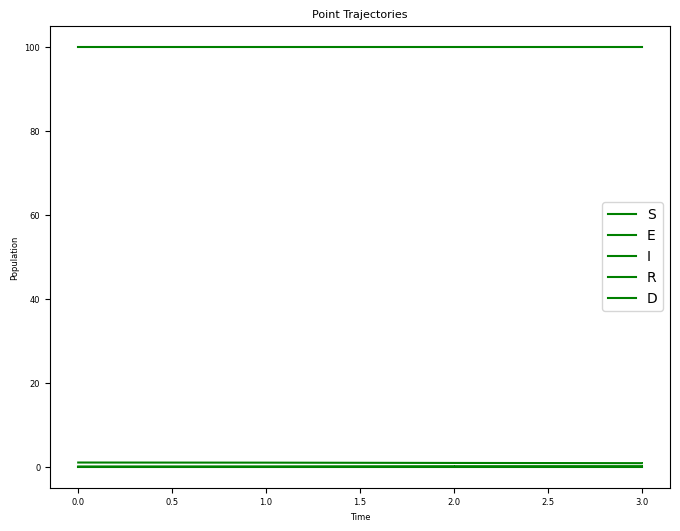

********************************************************************************
********************************************************************************
* Analysis Summary
********************************************************************************
1 Points (+:1, -:0), 1 Boxes (+:1, -:0)
Parameters = {S0[100.0, 100.0): 100.0, I0[1.0, 1.0): 1.0, E0[0.0, 0.0): 0.0, R0[0.0, 0.0): 0.0, H0[0.0, 0.0): 0.0, D0[0.0, 0.0): 0.0, N[101.0, 101.0): 101.0, beta[-1, 1.0): 0.0, r_E_to_I[-1, 1.0): 0.4350498947284498, p_I_to_R[-1, 1.0): 0.9584566895868014, r_I_to_R[-1, 1.0): -0.03209451372484012, p_I_to_H[-1, 1.0): 0.0904644845996254, r_I_to_H[-1, 1.0): 0.9476508573091579, p_H_to_R[-1, 1.0): 0.41364379342783325, r_H_to_R[-1, 1.0): 0.8532890826942415, p_H_to_D[-1, 1.0): -0.8630377970749877, r_H_to_D[-1, 1.0): -0.9528554925516614}
        # {S0[100.0, 100.0): 100.0, I0[1.0, 1.0): 1.0, E0[0.0, 0.0): 0.0, R0[0.0, 0.0): 0.0, H0[0.0, 0.0): 0.0, D0[0.0, 0.0): 0.0, N[101.0, 101.0): 101.0, beta[-1, 

In [43]:
# SEIRD

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0, 1, 2, 3])

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"

    for p in ["beta", "r_H_to_D", "r_E_to_I", "p_I_to_R", "r_I_to_R",  "p_I_to_H", "r_I_to_H", "p_H_to_R", "r_H_to_R","p_H_to_D","r_H_to_D"]:
        param = funman_request.parameter(p)
        param.interval.lb = -1
        param.interval.ub = 1.0

    # S is not increasing, s_t >= s_{t+1}
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0, closed_upper_bound=True), variables=["S"], derivative=True)
    funman_request.constraints.append(c1)

    # # R is increasing, r_t <= r_{t+1}
    # c2 = LinearConstraint(name="c2", additive_bounds=Interval(lb=0), variables=["R"], derivative=True)
    # funman_request.constraints.append(c2)

    # # D is increasing, d_t <= d_{t+1}
    # c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["D"], derivative=True)
    # funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=101, ub=101, closed_upper_bound=True), variables=["S", "E", "I", "R", "D"])
    funman_request.constraints.append(c4)

    funman_request.constraints.append(StateVariableConstraint(name="SB", variable="S", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="EB", variable="E", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="IB", variable="I", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="RB", variable="R", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="DB", variable="D", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))

    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    print(summary)

In [44]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[["S", "E", "I", "R", "D"]]
# df["S"]+df["E"]+df["I"]+df["D"]

,S,E,I,R,D
time,,,,,
0.0,100.0,0.0,1.000000,0.000000,0.000000
1.0,100.0,0.0,0.970572,0.029428,0.000000
2.0,100.0,0.0,0.900911,0.039638,0.082231
3.0,100.0,0.0,0.849578,0.041131,0.110394


In [5]:
# Stratified

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0,1, 2])
    funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
#     funman_request.config.use_compartmental_constraints=False
#     r_H_to_D = funman_request.parameter("r_H_to_D")
#     r_H_to_D.interval.lb = 0
#     r_H_to_D.interval.ub = 1.0

    # r_E_to_I = funman_request.parameter("r_E_to_I")
    # r_E_to_I.interval.lb = 0
    # r_E_to_I.interval.ub = 1.0


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    # summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    # print(summary)

2024-02-24 14:35:06,560 - funman.server.worker - INFO - FunmanWorker running...
2024-02-24 14:35:06,566 - funman.server.worker - INFO - Starting work on: 73b12a36-418f-4419-841a-914e6e69253a
[1.00000, 1.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.00000, 0.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[1.00000, 1.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.52000, 0.52000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.00000, 0.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.00000, 0.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
[0.00000, 0.00000) has 

In [6]:
results_unconstrained_point.parameter_space.points()[0]

{'type': 'point', 'label': 'true', 'values': {'chi_0': 1.0, 'd_0_0': 5.1706308169596694e-08, 'phi_0': 1.0, 'q': 0.52, 'd_0_1': 5.1706308169596694e-08, 'd_0_2': 5.1706308169596694e-08, 'd_0_3': 5.1706308169596694e-08, 'chi_1': 1.0, 'chi_2': 1.0, 'phi_1': 1.0, 'd_1_0': 5.1706308169596694e-08, 'd_1_1': 5.1706308169596694e-08, 'd_1_2': 5.1706308169596694e-08, 'd_1_3': 5.1706308169596694e-08, 'd_2_0': 5.1706308169596694e-08, 'd_2_1': 5.1706308169596694e-08, 'd_2_2': 5.1706308169596694e-08, 'd_2_3': 5.1706308169596694e-08, 'd_3_0': 5.1706308169596694e-08, 'd_3_1': 5.1706308169596694e-08, 'd_3_2': 5.1706308169596694e-08, 'd_3_3': 5.1706308169596694e-08, 'rho': 0.5, 'eta_0_0_0': 0.1, 'gamma': 0.2, 'eta_0_0_1': 0.1, 'eta_0_1_0': 0.1, 'eta_0_1_1': 0.1, 'eta_0_2_0': 0.1, 'eta_0_2_1': 0.1, 'eta_1_0_0': 0.1, 'eta_1_0_1': 0.1, 'eta_1_1_0': 0.1, 'eta_1_1_1': 0.1, 'eta_1_2_0': 0.1, 'eta_1_2_1': 0.1, 'eta_2_0_0': 0.1, 'eta_2_0_1': 0.1, 'eta_2_1_0': 0.1, 'eta_2_1_1': 0.1, 'eta_2_2_0': 0.1, 'eta_2_2_1': 